# Support Vector Machines

In [5]:
import numpy as np
import pickle as pkl
from scipy import optimize
from scipy.linalg import cho_factor, cho_solve
import matplotlib.pyplot as plt
from utils import plotClassification, plotRegression, plot_multiple_images, generateRings, scatter_label_points, loadMNIST
import time


## Loading the data

The file 'classification_datasets' contains 3 small classification datasets:
    
    - dataset_1: mixture of two well separated gaussians
    - dataset_2: mixture of two gaussians that are not separeted
    - dataset_3: XOR dataset that is non-linearly separable.
   
Each dataset is a hierarchical dictionary with the following structure:
        
        dataset = {'train': {'x': data, 'y':label}
                    'test': {'x': data, 'y':label}
                  }
The data $x$ is an $N$ by $2$ matrix, while the label $y$ is a vector of size $N$. 

Only the third dateset is used. 

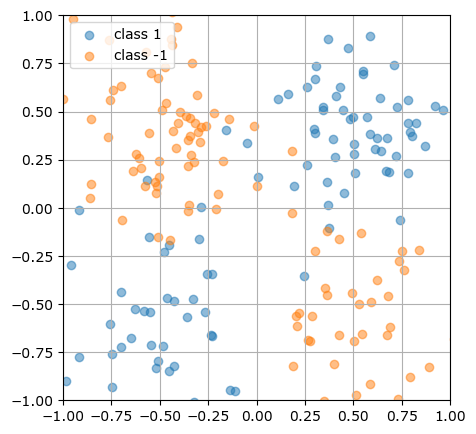

In [6]:
file = open('datasets/classification_datasets', 'rb')
datasets = pkl.load(file)
file.close()
dataset = datasets['dataset_3']

fig, ax = plt.subplots(1,1, figsize=(5, 5))
plotClassification(dataset['train']['x'], dataset['train']['y'], ax=ax)


## III- Kernel SVC 
### 1- Implementing the Gaussian Kernel
Implement the method 'kernel' of the class RBF below, which takes as input two data matrices $X$ and $Y$ of size $N\times d$ and $M\times d$ and returns a gramm matrix $G$ of shape $N\times M$ whose components are $k(x_i,y_j) = \exp(-\Vert x_i-y_j\Vert^2/(2\sigma^2))$. (The fastest solution does not use any for loop!)

In [7]:
class RBF:
    # $X$ and $Y$ of size $N\times d$ and $M\times d$ and returns a gramm matrix $G$ of shape $N\times M$ whose components are $k(x_i,y_j) = \exp(-\Vert x_i-y_i\Vert^2/(2\sigma^2))$.
    # (The fastest solution does not use any for loop!)
    def __init__(self, sigma=1.):
        self.sigma = sigma  ## the variance of the kernel
    def kernel(self,X,Y):
        gamma = 1/(2*self.sigma**2)
        X_dims = X.ndim
        Y_dims = Y.ndim
        if X_dims == 1 and Y_dims == 1:
            return np.exp(-gamma * np.linalg.norm(X - Y)**2)
        elif (X_dims > 1 and Y_dims == 1) or (X_dims == 1 and Y_dims > 1):
            return np.exp(-gamma * np.linalg.norm(X - Y, axis = 1)**2)
        elif X_dims > 1 and Y_dims > 1:
            return np.exp(-gamma * np.linalg.norm(X[:, np.newaxis] - Y[np.newaxis, :], axis = 2)**2)
# Test the RBF kernel
rbf = RBF(sigma=1.)
gram = rbf.kernel(dataset['train']['x'], dataset['train']['x'])
print(gram.shape)
print(len(np.linalg.eigvals(gram)), 'eigenvalues')
# make sure it's symmetric
print('symmetric', np.allclose(gram, gram.T))
# make sure the eigenvalues are positive
print('min eigenvalue', np.min(np.linalg.eigvals(gram)))


(200, 200)
200 eigenvalues
symmetric True
min eigenvalue (-3.582901967438421e-15+0j)


In [8]:
class linear:
    def __init__(self):
        pass
    def kernel(self,X,Y):
        return np.dot(X,Y.T)
    
#test
linear = linear()


### 2- Implementing the classifier
Implement the methods 'fit' and 'separating_function' of the class KernelSVC below to learn the Kernel Support Vector Classifier.

In [9]:
class KernelSVC: 
    def __init__(self, C, kernel, epsilon = 1e-3):
        self.type = 'non-linear'
        self.C = C                               
        self.kernel = kernel        
        self.alpha = None
        self.support = None
        self.epsilon = epsilon
        self.norm_f = None
        self.X = None
    def fit(self, X, y):
        N,self.X,kernel_XX = len(y), X, self.kernel(X,X)
        def loss(alpha):
            return 0.5 * (np.diag(y) @ alpha).T @ kernel_XX @ np.diag(y) @ alpha - alpha.T @ np.ones((N,1))
        def grad_loss(alpha):  
            return np.diag(y) @ kernel_XX @ np.diag(y) @ alpha - np.ones((N,))
        fun_ineq_1 = lambda alpha: alpha
        jac_ineq_1 = lambda alpha: np.eye(N)
        fun_ineq_2 = lambda alpha: self.C - alpha
        jac_ineq_2 = lambda alpha: -np.eye(N)
        fun_eq = lambda alpha: np.dot(y,alpha)
        constraints = [{'type': 'ineq', 'fun': fun_ineq_1 , 'jac': jac_ineq_1},
                       {'type': 'ineq', 'fun': fun_ineq_2, 'jac': jac_ineq_2},
                        {'type': 'eq', 'fun': fun_eq ,'jac': lambda alpha: y}]
        optRes = optimize.minimize(fun=lambda alpha: loss(alpha),
                                   x0=np.ones(N), 
                                   method='SLSQP', 
                                   jac=lambda alpha: grad_loss(alpha), 
                                   constraints=constraints,
                                   )
        self.alpha = optRes.x
        self.alpha[self.alpha < 0] = 0 # set negative values to 0
        self.alpha[self.alpha > self.C] = self.C # set values greater than C to C
        self.alpha = y * self.alpha # multiply by y to get the final alpha
        ## compute the support vectors as alpha > 0 and alpha < C)
        indexes =  np.array([i for i in range(N) if (self.alpha[i] > self.epsilon) & (self.alpha[i] < self.C - self.epsilon)])
        self.support = X[indexes,:] 
        self.b = np.mean(y[indexes] - np.dot(self.kernel(self.support,X), self.alpha)) # compute the bias as the average of the difference between the prediction and the true label on the support vectors
        self.norm_f = ((self.alpha).T @  kernel_XX @ self.alpha)**0.5
    ### takes a matrix of shape N′×d and returns a vector of size N′ of evaluations of f.
    def separating_function(self,x):
        # Input : matrix x of shape N data points times d dimension
        # Output: vector of size N
        K = self.kernel(x, self.X) #K is of N' * N'
        return np.dot(K, self.alpha)  
    def predict(self, X):
        """ Predict y values in {-1, 1} """
        d = self.separating_function(X)
        return 2 * (d+self.b> 0) - 1

### 2- Fitting the classifier

Run the code block below to fit the classifier and report its output.

In [10]:
sigma = 1.5
C=100.
kernel = RBF(sigma).kernel
model = KernelSVC(C=C, kernel=kernel)
train_dataset = datasets['dataset_3']['train']
model.fit(train_dataset['x'], train_dataset['y'])


Number of support vectors = 4


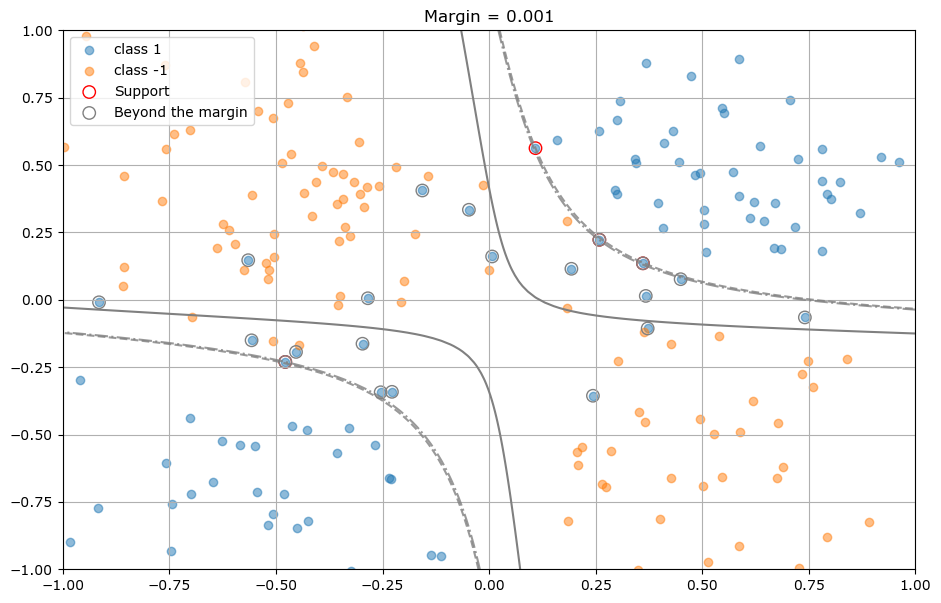

In [11]:
plotClassification(train_dataset['x'], train_dataset['y'], model, label='Training')

### USING BUILT-IN FUNCTIONS

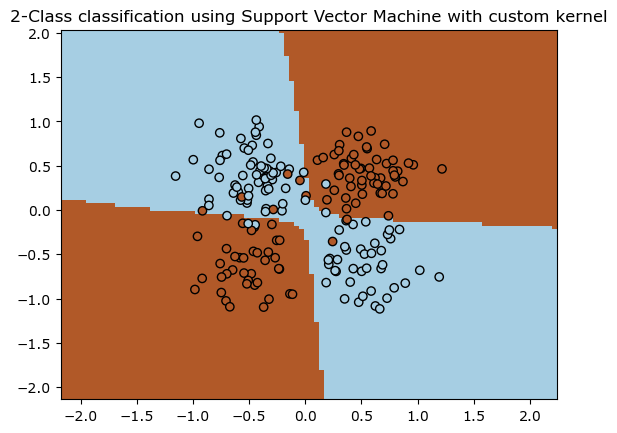

In [12]:
# do the same thing using sklearn SVC library
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, datasets
from sklearn.inspection import DecisionBoundaryDisplay

clf = svm.SVC(C=C, kernel='rbf', gamma=1/(2*sigma**2))
clf.fit(train_dataset['x'], train_dataset['y'])
X = train_dataset['x']
Y = train_dataset['y']
ax = plt.gca()
DecisionBoundaryDisplay.from_estimator(
    clf,
    X,
    cmap=plt.cm.Paired,
    ax=ax,
    response_method="predict",
    plot_method="pcolormesh",
    shading="auto",
)

# Plot also the training points
plt.scatter(X[:, 0], X[:, 1], c=Y, cmap=plt.cm.Paired, edgecolors="k")
plt.title("2-Class classification using Support Vector Machine with custom kernel")
plt.axis("tight")
plt.show()

 

# Kernel Regression

## Loading the data

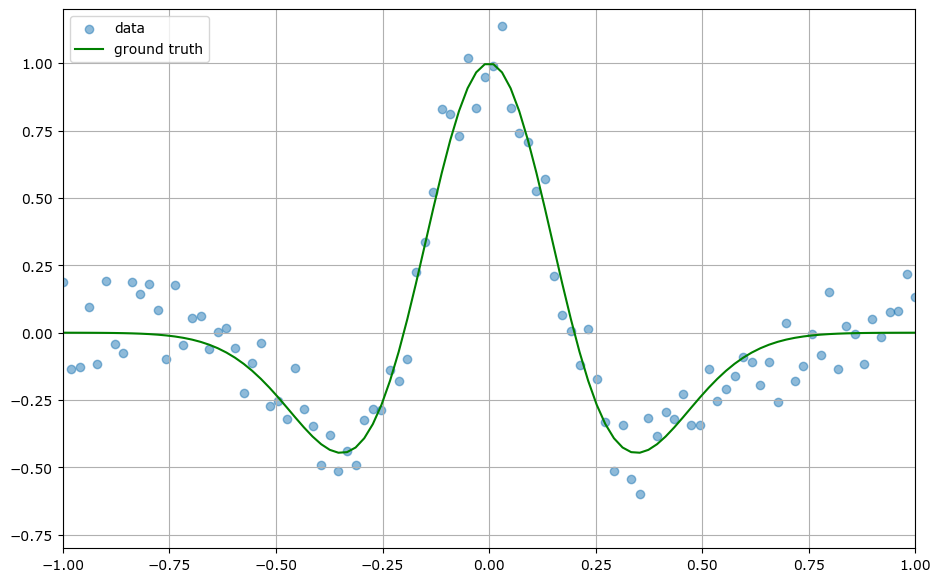

In [13]:
file = open('datasets/regression_datasets', 'rb')
datasets = pkl.load(file)
file.close()
train_set = datasets['dataset_1']['train']
train_set = datasets['dataset_1']['test']
plotRegression(train_set['x'], train_set['y'],Y_clean= train_set['y_clean'])


## Kernel Ridge Regression
### 1- Implementing the regressor
Implement the method 'fit' of the classes KernelRR and MultivariateKernelRR below to perform Kernel Ridge Regression. 


In [14]:
class KernelRR:
    
    def __init__(self,kernel,lmbda):
        self.lmbda = lmbda                    
        self.kernel = kernel    
        self.alpha = None 
        self.b = None
        self.support = None
        self.type='ridge'
        
    def fit(self, X, y):
        n = X.shape[0]
        self.support = X
        self.alpha = np.linalg.inv(self.kernel(X,X) + n*self.lmbda*np.eye(n)) @ y # lambda is supposed positive
        self.b =  y - np.dot(self.kernel(X,X), self.alpha)
         
    ### Implementation of the separting function $f$ 
    def regression_function(self,x):
        # Input : matrix x of shape N data points times d dimension
        # Output: vector of size N
        return  np.dot(self.kernel(x, self.support), self.alpha) + self.b

    def predict(self, X):
        """ Predict y values in {-1, 1} """
        return self.regression_function(X) 
    
class MultivariateKernelRR:      
    def __init__(self,kernel,lmbda):
        self.lmbda = lmbda                    
        self.kernel = kernel
        self.support = None
        self.alpha = None
        self.b = None
        self.type='ridge'
    
    def fit(self, X, y):
        self.support = X
        self.alpha = np.linalg.inv(self.kernel(X,X) + self.lmbda*np.eye(X.shape[0])) @ y
        self.b =  y - np.dot(self.kernel(X,X), self.alpha)
    ### Implementation of the separting function $f$ 
    def regression_function(self,x):
        # Input : matrix x of shape N data points times d dimension
        # Output: vector of size N
        return  np.dot(self.kernel(x, self.support), self.alpha) 
    
    def predict(self, X):
        """ Predict y values in {-1, 1} """
        return self.regression_function(X) + np.expand_dims(self.b,axis=0)
    

### 2- Fitting the regressor

Run the code block below to fit the regressor and report its output.

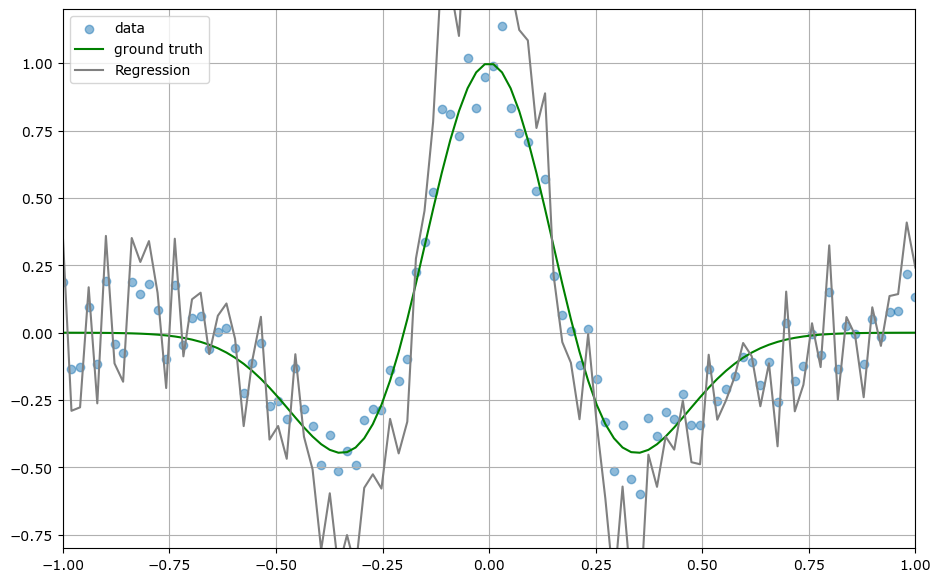

In [15]:
sigma = 0.2
lmbda = .1
kernel = RBF(sigma).kernel
model = KernelRR(kernel, lmbda=lmbda)
model.fit(train_set['x'].reshape(-1,1),train_set['y'])
plotRegression(train_set['x'], train_set['y'], Y_clean= train_set['y_clean'], model=model, label='Train')

# Kernel PCA

### 1- Implementing kernel PCA
Implement the method 'fit' of the classes KernelSVR below to perform Kernel Support Vector Regression. 

In [36]:
class KernelPCA:
    
    def __init__(self,kernel, r=2):                             
        self.kernel = kernel          # <---
        self.alpha = None # Matrix of shape N times d representing the d eingenvectors alpha corr
        self.lmbda = None # Vector of size d representing the top d eingenvalues
        self.support = None # Data points where the features are evaluated
        self.r =r ## Number of principal components
    
    def compute_PCA(self, X):
        N = X.shape[0]
        # Compute the kernel matrix using the kernel function
        K = self.kernel(X, X)
        # compute G the centered kernel matrix
        U = np.ones((N,N))/N
        G = K - np.dot(K,U) - np.dot(U,K) + np.dot(np.dot(U,K), U)
        # Set the support points to be the input data points
        self.support = X
        # Compute the top r eigenvalues and eigenvectors of the kernel matrix
        eigenvalues, eigenvectors = np.linalg.eigh(G)
        # Sort the eigenvalues and eigenvectors in decreasing order of eigenvalues
        indexes = sorted(range(len(eigenvalues)), key=lambda k: eigenvalues[k])
        self.lmbda = eigenvalues[indexes][:self.r]
        self.alpha = eigenvectors[:,indexes][:,:self.r]
        
    def transform(self,x):
        # Input : matrix x of shape N data points times d dimension
        # Output: vector of size N
        # Compute the kernel matrix between the input data points and the support point
        K = self.kernel(x, self.support)
        return K @ (self.alpha)
    

### 2- Performing kernel PCA

Run the code block below apply a kernel PCA to a dataset consisting of three concentric rings and report the output. What can you conclude about this dataset?

(100,)


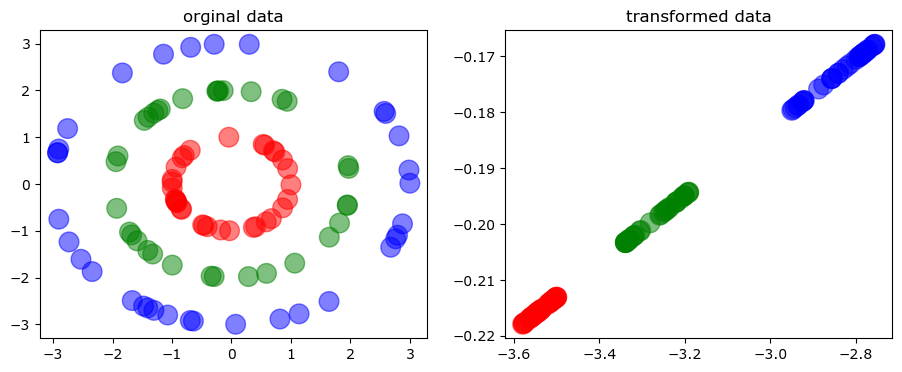

In [37]:
file = open('datasets/pca_datasets', 'rb')
datasets = pkl.load(file)
file.close()
train_set = datasets['dataset_1']['train']
test_set = datasets['dataset_1']['test']

sigma = 4.
kernel = RBF(sigma).kernel
pca = KernelPCA(kernel, r=2)
pca.compute_PCA(train_set['x'])
pca_components = pca.transform(test_set['x'])
print(test_set['y'].shape) # contains 3 labels 0,1,2 with same number of points 33

fig, ax = plt.subplots(1,2, figsize=(11, 4))
scatter_label_points(test_set['x'], test_set['y'], ax[0], title='orginal data')
scatter_label_points(pca_components,test_set['y'], ax[1], title= 'transformed data')



# Denoising 
### 1- Implementing a denoiser based on Kernel PCA and Kernel Ridge Regression
Implement the methods 'fit' and 'denoise' of the classes Denoiser below. 

In [ ]:
class Denoiser:
    def __init__(self, kernel_encoder, kernel_decoder,dim_pca, lmbda):
        self.pca = KernelPCA(kernel_encoder, r=dim_pca)
        self.ridge_reg = MultivariateKernelRR(kernel_decoder, lmbda= lmbda)
    
    def fit(self,train):
        self.pca.compute_PCA(train) # encode the data
        transformed = self.pca.transform(train) # transform the data
        # print shape of transformed data
        print("transformed shape", transformed.shape)
        print("train shape", train.shape)
        self.ridge_reg.fit(train , transformed)
         
        
    def denoise(self,test):
        return self.ridge_reg.predict(self.pca.transform(test))
 

### 2- Denoising MNIST dataset

Run the code block below to perform denoising of a subset of MNIST digits dataset and report the output. To what extend the denoising is successful? How can it be improved?

In [ ]:
datasets = loadMNIST('datasets/SubsetMNIST')
clean_data = datasets['cleanMNIST']
data = datasets['noisyMNIST']


dim_pca =80
lmbda = 10.
sigma_encoder =8.
sigma_decoder =.5
kernel_encoder = RBF(sigma_encoder).kernel
kernel_decoder = RBF(sigma_decoder).kernel
denoiser = Denoiser(kernel_encoder,kernel_decoder,dim_pca, lmbda)

denoiser.fit(data['train']) # shape of train set (2000, 28, 28)
pred = denoiser.denoise(data['test']) # shape of test set (2000, 28, 28)

plot_multiple_images(clean_data['test'])
plot_multiple_images(data['test'])
plot_multiple_images(pred)

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn_extra.cluster import KMedoids

In [26]:
input_file = 'medoid.PNG.csv'
# read the input file
X = pd.read_csv(input_file)

In [30]:
X.head()

,Athens,Barcelona,Brussels,Geneva,Gibraltar,Lisbon,Lyons,Madrid,Paris,Rome,Vienna
Athens,0,3313,2963,2610,4485,4532,2753,3949,3000,817,1991
Barcelona,3313,0,1318,803,1172,1305,645,636,1033,1460,1802
Brussels,2963,1318,0,677,2256,2084,690,1558,285,1511,1175
Geneva,2610,803,677,0,1975,1936,158,1439,513,995,1019
Gibraltar,4485,1172,2256,1975,0,676,1817,698,1971,2631,2974


In [27]:
# construct the dissimilarity matrix

In [ ]:
import tensorflow as tf
from tensorflow.python.client import timeline

# Build the computation graph
with tf.Session() as sess:
    run_options = tf.RunOptions(trace_level=tf.RunOptions.FULL_TRACE)
    run_metadata = tf.RunMetadata()